In [1]:
%matplotlib inline
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
import os

# Manually set the path to your fma_small data folder
# Use the relative path:
AUDIO_DIR = '/Users/ajanshul02gmail.com/T-5/Project/Ph 1/fma_small'

# OR use the absolute path based on your file structure:
# AUDIO_DIR = '/Users/ajanshul02gmail.com/T-5/Project/Data sets/github/data/fma_small'

# Check if the directory actually exists to avoid future errors
if not os.path.exists(AUDIO_DIR):
    print(f"WARNING: The directory {AUDIO_DIR} does not exist. Please check your path.")

# Load metadata and features.
tracks = utils.load('/Users/ajanshul02gmail.com/T-5/Project/Data sets/tracks.csv')
genres = utils.load('/Users/ajanshul02gmail.com/T-5/Project/Data sets/genres.csv')
features = utils.load('/Users/ajanshul02gmail.com/T-5/Project/Data sets/features.csv')
echonest = utils.load('/Users/ajanshul02gmail.com/T-5/Project/Data sets/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

print(tracks.shape, genres.shape, features.shape, echonest.shape)

(106574, 52) (163, 4) (106574, 518) (13129, 249)


File: /Users/ajanshul02gmail.com/T-5/Project/Ph 1/fma_small/000/000002.mp3
Duration: 29.98s, 1321967 samples


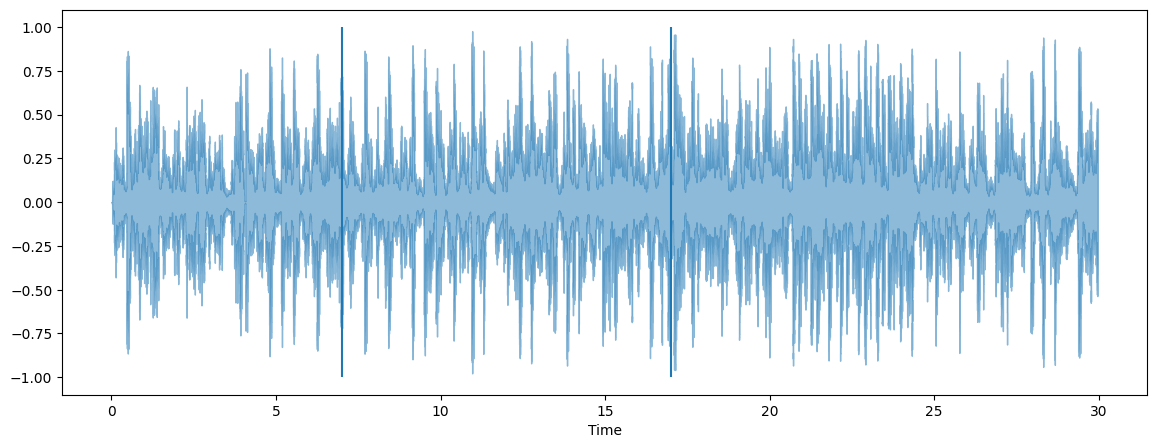

In [3]:
filename = utils.get_audio_path(AUDIO_DIR, 2)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

# Waveplot is now waveshow
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr, alpha=0.5)
plt.vlines([start, end], -1, 1)
plt.show()

In [4]:
import time
import os
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
import sklearn as skl
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# TensorFlow/Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam

# Import utils (ensure utils.py is in the same folder)
import utils

# ---------------------------------------------------------
# 0. M4 / METAL CHECK
# ---------------------------------------------------------
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Detected: {gpus[0]}")
    print("🚀 Training will run on Apple Silicon Metal GPU.")
else:
    print("⚠️ No GPU detected. Running on CPU (slower).")
    print("   Make sure you installed: pip install tensorflow-metal")

# ---------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------

# Audio Directory
AUDIO_DIR = '/Users/ajanshul02gmail.com/T-5/Project/Ph 1/fma_small'

# Metadata Paths
TRACKS_PATH = '/Users/ajanshul02gmail.com/T-5/Project/Data sets/tracks.csv'
FEATURES_PATH = '/Users/ajanshul02gmail.com/T-5/Project/Data sets/features.csv'
ECHONEST_PATH = '/Users/ajanshul02gmail.com/T-5/Project/Data sets/echonest.csv'
GENRES_PATH = '/Users/ajanshul02gmail.com/T-5/Project/Data sets/genres.csv'

# Check if audio dir exists
if not os.path.exists(AUDIO_DIR):
    print(f"WARNING: Audio directory {AUDIO_DIR} not found.")

# ---------------------------------------------------------
# 2. LOAD DATA
# ---------------------------------------------------------
print("\nLoading metadata...")
tracks = utils.load(TRACKS_PATH)
features = utils.load(FEATURES_PATH)
echonest = utils.load(ECHONEST_PATH)
genres = utils.load(GENRES_PATH)

# Verify data integrity
np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()
print(f"Loaded: Tracks {tracks.shape}, Features {features.shape}, Echonest {echonest.shape}")

# ---------------------------------------------------------
# 3. PREPARE SUBSETS (Small/Medium)
# ---------------------------------------------------------
# We use 'small' or 'medium' subset to ensure we have audio files
subset = tracks.index[tracks['set', 'subset'] <= 'small']
tracks = tracks.loc[subset]
features_all = features.loc[subset]

# Indices for Split
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print(f"Split: {len(train)} Train, {len(val)} Val, {len(test)} Test")

# ---------------------------------------------------------
# 4. CLASSICAL MACHINE LEARNING (Feature-based)
# ---------------------------------------------------------
print("\n--- Starting Classical Classification (MFCCs) ---")

def pre_process(tracks, features, columns):
    # Encode Labels (Genres)
    enc = LabelEncoder()
    labels = tracks['track', 'genre_top']
    
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    
    # Select Features
    X_train = features.loc[train, columns].values
    X_val = features.loc[val, columns].values
    X_test = features.loc[test, columns].values
    
    # Shuffle Training Data
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    # Standardize Features (Zero mean, unit variance)
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)
    
    return y_train, y_val, y_test, X_train, X_val, X_test

# Define Models
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC (RBF)': SVC(kernel='rbf'),
    'MLP (Neural Net)': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
}

# Preprocess data using MFCC features
y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, 'mfcc')

# Train and Evaluate
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"  {name} Test Accuracy: {score:.2%}")

# ---------------------------------------------------------
# 5. DEEP LEARNING (Raw Audio CNN)
# ---------------------------------------------------------
print("\n--- Starting Deep Learning (CNN on Raw Audio) ---")

# One-Hot Encode Targets for Keras
labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

# Initialize Audio Loader (ffmpeg)
# sampling_rate=16000 is common for deep learning on audio
loader = utils.FfmpegLoader(sampling_rate=16000)

# Create Data Generator Class
SampleLoader = utils.build_sample_loader(AUDIO_DIR, labels_onehot, loader)

print(f"Audio Loader initialized. Shape: {loader.shape}")

# Build CNN Model (Keras)
keras.backend.clear_session()
model = keras.models.Sequential()

# Reshape input: (samples, time_steps, channels)
model.add(Reshape((-1, 1), input_shape=loader.shape))

# Conv Layer 1
model.add(Conv1D(filters=64, kernel_size=512, strides=512))
model.add(Activation("relu"))
model.add(BatchNormalization())

# Conv Layer 2
model.add(Conv1D(filters=32, kernel_size=8))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))

# Conv Layer 3
model.add(Conv1D(filters=32, kernel_size=8))
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))

# Flatten & Dense
model.add(Flatten())
model.add(Dense(100))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))

# Compile
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train Configuration for M4
BATCH_SIZE = 64  # Increased for M4 efficiency
EPOCHS = 10      # Increased slightly to see learning

print(f"Starting Training (Batch Size: {BATCH_SIZE})...")

# --- GENERATOR FIX ---
# Wrap the SampleLoader in a Python generator expression for Keras 3 compatibility
train_loader = SampleLoader(train, batch_size=BATCH_SIZE)
val_loader = SampleLoader(val, batch_size=BATCH_SIZE)

train_gen = (batch for batch in train_loader)
val_gen = (batch for batch in val_loader)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=len(val) // BATCH_SIZE
)

# Evaluate
print("Evaluating on Test set...")
test_loader = SampleLoader(test, batch_size=BATCH_SIZE)
test_gen = (batch for batch in test_loader)

loss, acc = model.evaluate(
    test_gen, 
    steps=len(test) // BATCH_SIZE
)
print(f"\nCNN Test Accuracy: {acc:.2%}")

TensorFlow Version: 2.16.1
✅ GPU Detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
🚀 Training will run on Apple Silicon Metal GPU.

Loading metadata...
Loaded: Tracks (106574, 52), Features (106574, 518), Echonest (13129, 249)
Split: 6400 Train, 800 Val, 800 Test

--- Starting Classical Classification (MFCCs) ---
Training LogisticRegression...
  LogisticRegression Test Accuracy: 41.00%
Training SVC (RBF)...
  SVC (RBF) Test Accuracy: 46.38%
Training MLP (Neural Net)...
  MLP (Neural Net) Test Accuracy: 39.38%

--- Starting Deep Learning (CNN on Raw Audio) ---
Audio Loader initialized. Shape: (479625,)


/Users/ajanshul02gmail.com/.virtualenvs/cool/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:38: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-12-06 13:23:13.422388: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-06 13:23:13.422419: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-06 13:23:13.422428: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-06 13:23:13.422896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-06 13:23:13.422914: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 479625, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 936, 64)        │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 936, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 936, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 929, 32)        │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 929, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 464, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 457, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 457, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 228, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7296)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       729,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 788,236 (3.01 MB)

 Trainable params: 788,108 (3.01 MB)

 Non-trainable params: 128 (512.00 B)

Starting Training (Batch Size: 64)...
Epoch 1/10


2025-12-06 13:23:23.785404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 11/100 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - accuracy: 0.1483 - loss: 9.8587
Ignoring /Users/ajanshul02gmail.com/T-5/Project/Ph 1/fma_small/098/098567.mp3 (error: could not broadcast input array from shape (8167,) into shape (479625,)).
 12/100 ━━━━━━━━━━━━━━━━━━━━ 5:42 4s/step - accuracy: 0.1479 - loss: 9.7161
Ignoring /Users/ajanshul02gmail.com/T-5/Project/Ph 1/fma_small/098/098569.mp3 (error: could not broadcast input array from shape (24468,) into shape (479625,)).

Ignoring /Users/ajanshul02gmail.com/T-5/Project/Ph 1/fma_small/054/054576.mp3 (error: could not broadcast input array from shape (479434,) into shape (479625,)).
 26/100 ━━━━━━━━━━━━━━━━━━━━ 4:54 4s/step - accuracy: 0.1452 - loss: 7.8439
Ignoring /Users/ajanshul02gmail.com/T-5/Project/Ph 1/fma_small/017/017637.mp3 (error: could not broadcast input array from shape (479434,) into shape (479625,)).
 27/100 ━━━━━━━━━━━━━━━━━━━━ 4:51 4s/step - accuracy: 0.1448 - loss: 7.7417
Ignoring /Users/ajanshul02gmail.com/T-5/Project/Ph

KeyboardInterrupt: 